In [5]:
import pandas as pd
import json
import random
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load data

locations_file = "../data/locations.json"
item_lists_file = "../data/item_lists.json"
items_file = "../data/items.json"
plan_file = "../data/warehouse_plan.png"

In [7]:
class Location:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    
    def l1_distance(self, location):  # We use L1 (Manhattan) distance for this problem (grid problem)
        dx = np.abs(location.x - self.x)
        dy = np.abs(location.y - self.y)
        distance = dx + dy
        return distance
    
    def __str__(self):
        return f"{self.name}: {self.x}, {self.y}"

    
class Item:
    def __init__(self, name, location_names):
        self.name = name
        self.location_names = location_names
        
    def __str__(self):
        return f"Item {self.name}, {self.location_names}"
    
    
class Order:
    def __init__(self, order_name):
        self.order_name = order_name
        self.item_names = []
        self.qts = []
        self.locations = []
    
    def add_item(self, item, qt):
        self.item_names.append(item)
        self.qts.append(qt)
        
    def find_items(self, warehouse):
        for item_name in self.item_names:
            self.locations.append(warehouse.get_location_from_item_name(item_name))
            
    def __getitem__(self, index):
        return self.item_names[index]
        
    def __str__(self):
        p = "Order " + self.order_name + "\n"
        for item, qt in zip(self.item_names, self.qts):
            p = p + f" {item} ({qt})" 
        return p
    
    
class Orders:
    def __init__(self):
        self.orders = []
        
    def add_order(self, order):
        self.orders.append(order)
        
    def __getitem__(self, index):
        return self.orders[index]
        
    def __str__(self):
        p = ""
        for order in self.orders:
            p = p + str(order) + "\n"
        return p

In [40]:
class WareHouse:
    def __init__(self):
        self.locations = []
        self.items = []
        self.location_names = []
    
    def add_location(self, location):
        self.locations.append(location)
        self.location_names.append(location.name)
        
    def add_item(self, item):
        for loc in item.location_names:
            if loc not in self.location_names:
                raise Exception(f"Wrong location for {item}")
        self.items.append(item)
    
    def get_location_from_item_name(self, item_name):
        for item in self.items: 
            if item.name == item_name:
                location_name = item.location_names[0]  # We consider only the first location
                for loc in self.locations: 
                    if loc.name == location_name:
                        return loc
                    
    def get_location_from_name(self, location_name):
        for loc in self.locations: 
            if loc.name == location_name:
                return loc
                    
    def get_start_end(self):
        start = self.get_location_from_name("start")
        end = self.get_location_from_name("end")
        return start, end
        
    def __str__(self):
        p = "Locations\n"
        for location in self.locations:
            p = p + str(location) + "\n"
        p = p + "\n"
        for item in self.items:
            p = p + str(item) + "\n"
        return p

        
class Path:
    def __init__(self, warehouse, order=None, parent1=None, parent2=None, crossover_ratio=None, crossover=False):
        self.start, self.end = warehouse.get_start_end()
        if not crossover:
            self.generate_path(order)
        else:
            self.crossover(parent1, parent2, crossover_ratio)
        self.compute_distance()
            
    def generate_path(self, order):
        self.path = order.locations.copy()
        random.shuffle(self.path)
    
    def compute_distance(self):
        self.distance = 0
        # Start
        self.distance += self.start.l1_distance(self.path[0])
        # Path
        for i in range(len(self.path)-1):
            self.distance += self.path[i].l1_distance(self.path[i+1])
        # End
        self.distance += self.end.l1_distance(self.path[-1])
        return self.distance
    
    def crossover(self, parent1, parent2, crossover_ratio):
        split_indice = int(len(parent1) * crossover_ratio)
        child = parent1[:split_indice]
        for loc in parent2:
            if loc not in child:
                child.append(loc)
        self.path = child
        return child
    
    def add_start_end(self):
        self.path.insert(0, self.start)
        self.path.append(self.end)
    
    def __getitem__(self, index):
        return self.path[index]
    
    def __setitem__(self, index, value):
        self.path[index] = value
    
    def __len__(self):
        return len(self.path)

        
class Population:
    def __init__(self, order=None, warehouse=None, population_size=50, init_pop=False, new_pop=None):
        if init_pop:
            self.paths = []
            for i in range(population_size):
                self.paths.append(Path(warehouse, order=order))
        else:
            self.paths = new_pop
                
    def get_best_path(self, paths):
        best_distance = 1.e9
        best_indice = None
        for i, path in enumerate(paths):
            d = path.distance
            if d < best_distance:
                best_distance = d
                best_indice = i
        best_path = paths[best_indice]
        return best_indice, best_path, best_distance
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        return self.paths[index]
                
class GA:
    def __init__(self):
        self.mutation_rate = 0.02
        self.tournament_size = 5
        self.crossover_ratio = 0.2
        
    def evolve_population(self, pop):
        new_pop = []
        
        # Elitism
        best_indice, best_path, best_distance = pop.get_best_path(pop.paths)
        new_pop.append(best_path)

        # Tournament selection
        for i in range(1, len(pop)):
            parent1 = self.tournament_selection(pop)
            parent2 = self.tournament_selection(pop)
            child = Path(warehouse, parent1=parent1, parent2=parent2, crossover_ratio=self.crossover_ratio, crossover=True)
            new_pop.append(child)
            
        for i in range(1, len(pop)):
            self.mutate(new_pop[i])
        return Population(new_pop=new_pop)
            
    def tournament_selection(self, pop):
        paths = random.choices(pop, k=self.tournament_size)
        best_indice, best_path, best_distance = pop.get_best_path(paths)
        return best_path
    
    def mutate(self, path):
        # Mutation (swap two cities) based on a probability 
        if np.random.rand() < self.mutation_rate:
            n_loc = len(path)
            ind1 = np.random.randint(0, n_loc)
            ind2 = np.random.randint(0, n_loc)
            path1 = path[ind1]
            path[ind1] = path[ind2]
            path[ind2] = path1
        path.compute_distance()
        

In [41]:
# Load data
with open(locations_file) as file:
    locations = json.load(file)
    
with open(item_lists_file) as file:
    item_lists = json.load(file) 
    
with open(items_file) as file:
    items = json.load(file)

In [42]:
# Populate classes
warehouse = WareHouse()
for name, (x, y) in locations.items():
    location = Location(name, x, y)
    warehouse.add_location(location)
    
for name, location_names in items.items():
    item = Item(name, location_names)
    warehouse.add_item(item)
    
orders = Orders()
for order_name, order_data in item_lists.items():
    order = Order(order_name)
    for item_name, qt in order_data.items():
        order.add_item(item_name, qt)
    order.find_items(warehouse)
    orders.add_order(order)

iteration 0000	->	382.38 m
iteration 0050	->	294.50 m
iteration 0100	->	246.06 m
iteration 0150	->	246.06 m
iteration 0200	->	246.06 m
iteration 0250	->	246.06 m
iteration 0300	->	244.92 m
iteration 0350	->	244.92 m
iteration 0400	->	244.92 m
iteration 0450	->	244.92 m
iteration 0500	->	244.92 m
iteration 0550	->	244.92 m
iteration 0600	->	244.92 m
iteration 0650	->	238.15 m
iteration 0700	->	238.15 m
iteration 0750	->	238.15 m
iteration 0800	->	238.15 m
iteration 0850	->	238.15 m
iteration 0900	->	238.15 m
iteration 0950	->	238.15 m
iteration 1000	->	238.15 m
iteration 1050	->	238.15 m
iteration 1100	->	238.15 m
iteration 1150	->	238.15 m
iteration 1200	->	238.15 m
iteration 1250	->	238.15 m
iteration 1300	->	238.15 m
iteration 1350	->	238.15 m
iteration 1400	->	238.15 m
iteration 1450	->	238.15 m
iteration 1500	->	238.15 m
iteration 1550	->	238.15 m
iteration 1600	->	238.15 m
iteration 1650	->	238.15 m
iteration 1700	->	238.15 m
iteration 1750	->	238.15 m
iteration 1800	->	238.15 m
i

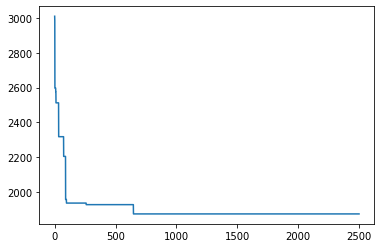

In [58]:
# Solve problem
n_order = 0
scale = 0.297*500/1169

pop_size = 50
max_iteration = 2500

order = orders[n_order]
pop = Population(order, warehouse, pop_size, True)
ga = GA()
history = {"distance": []}
for i in range(max_iteration):
    pop = ga.evolve_population(pop)
    best_indice, best_path, best_distance = pop.get_best_path(pop.paths)
    history["distance"].append(best_distance)
    if i%500 == 0 or not i or i == max_iteration-1:
        print(f"iteration {i:04d}\t->\t{best_distance*scale:.2f} m")
print("Done.")

best_path.add_start_end()

plt.plot(history["distance"])
plt.show()

pixel shape: (1169, 826, 4)
scale 1/500
1 pixel = 0.1270316509837468 m
['start', 'H30', 'H27', 'H21', 'G19', 'D6', 'B7', 'C2', 'O1', 'O19', 'O28', 'L32', 'L33', 'L36', 'L39', 'end']


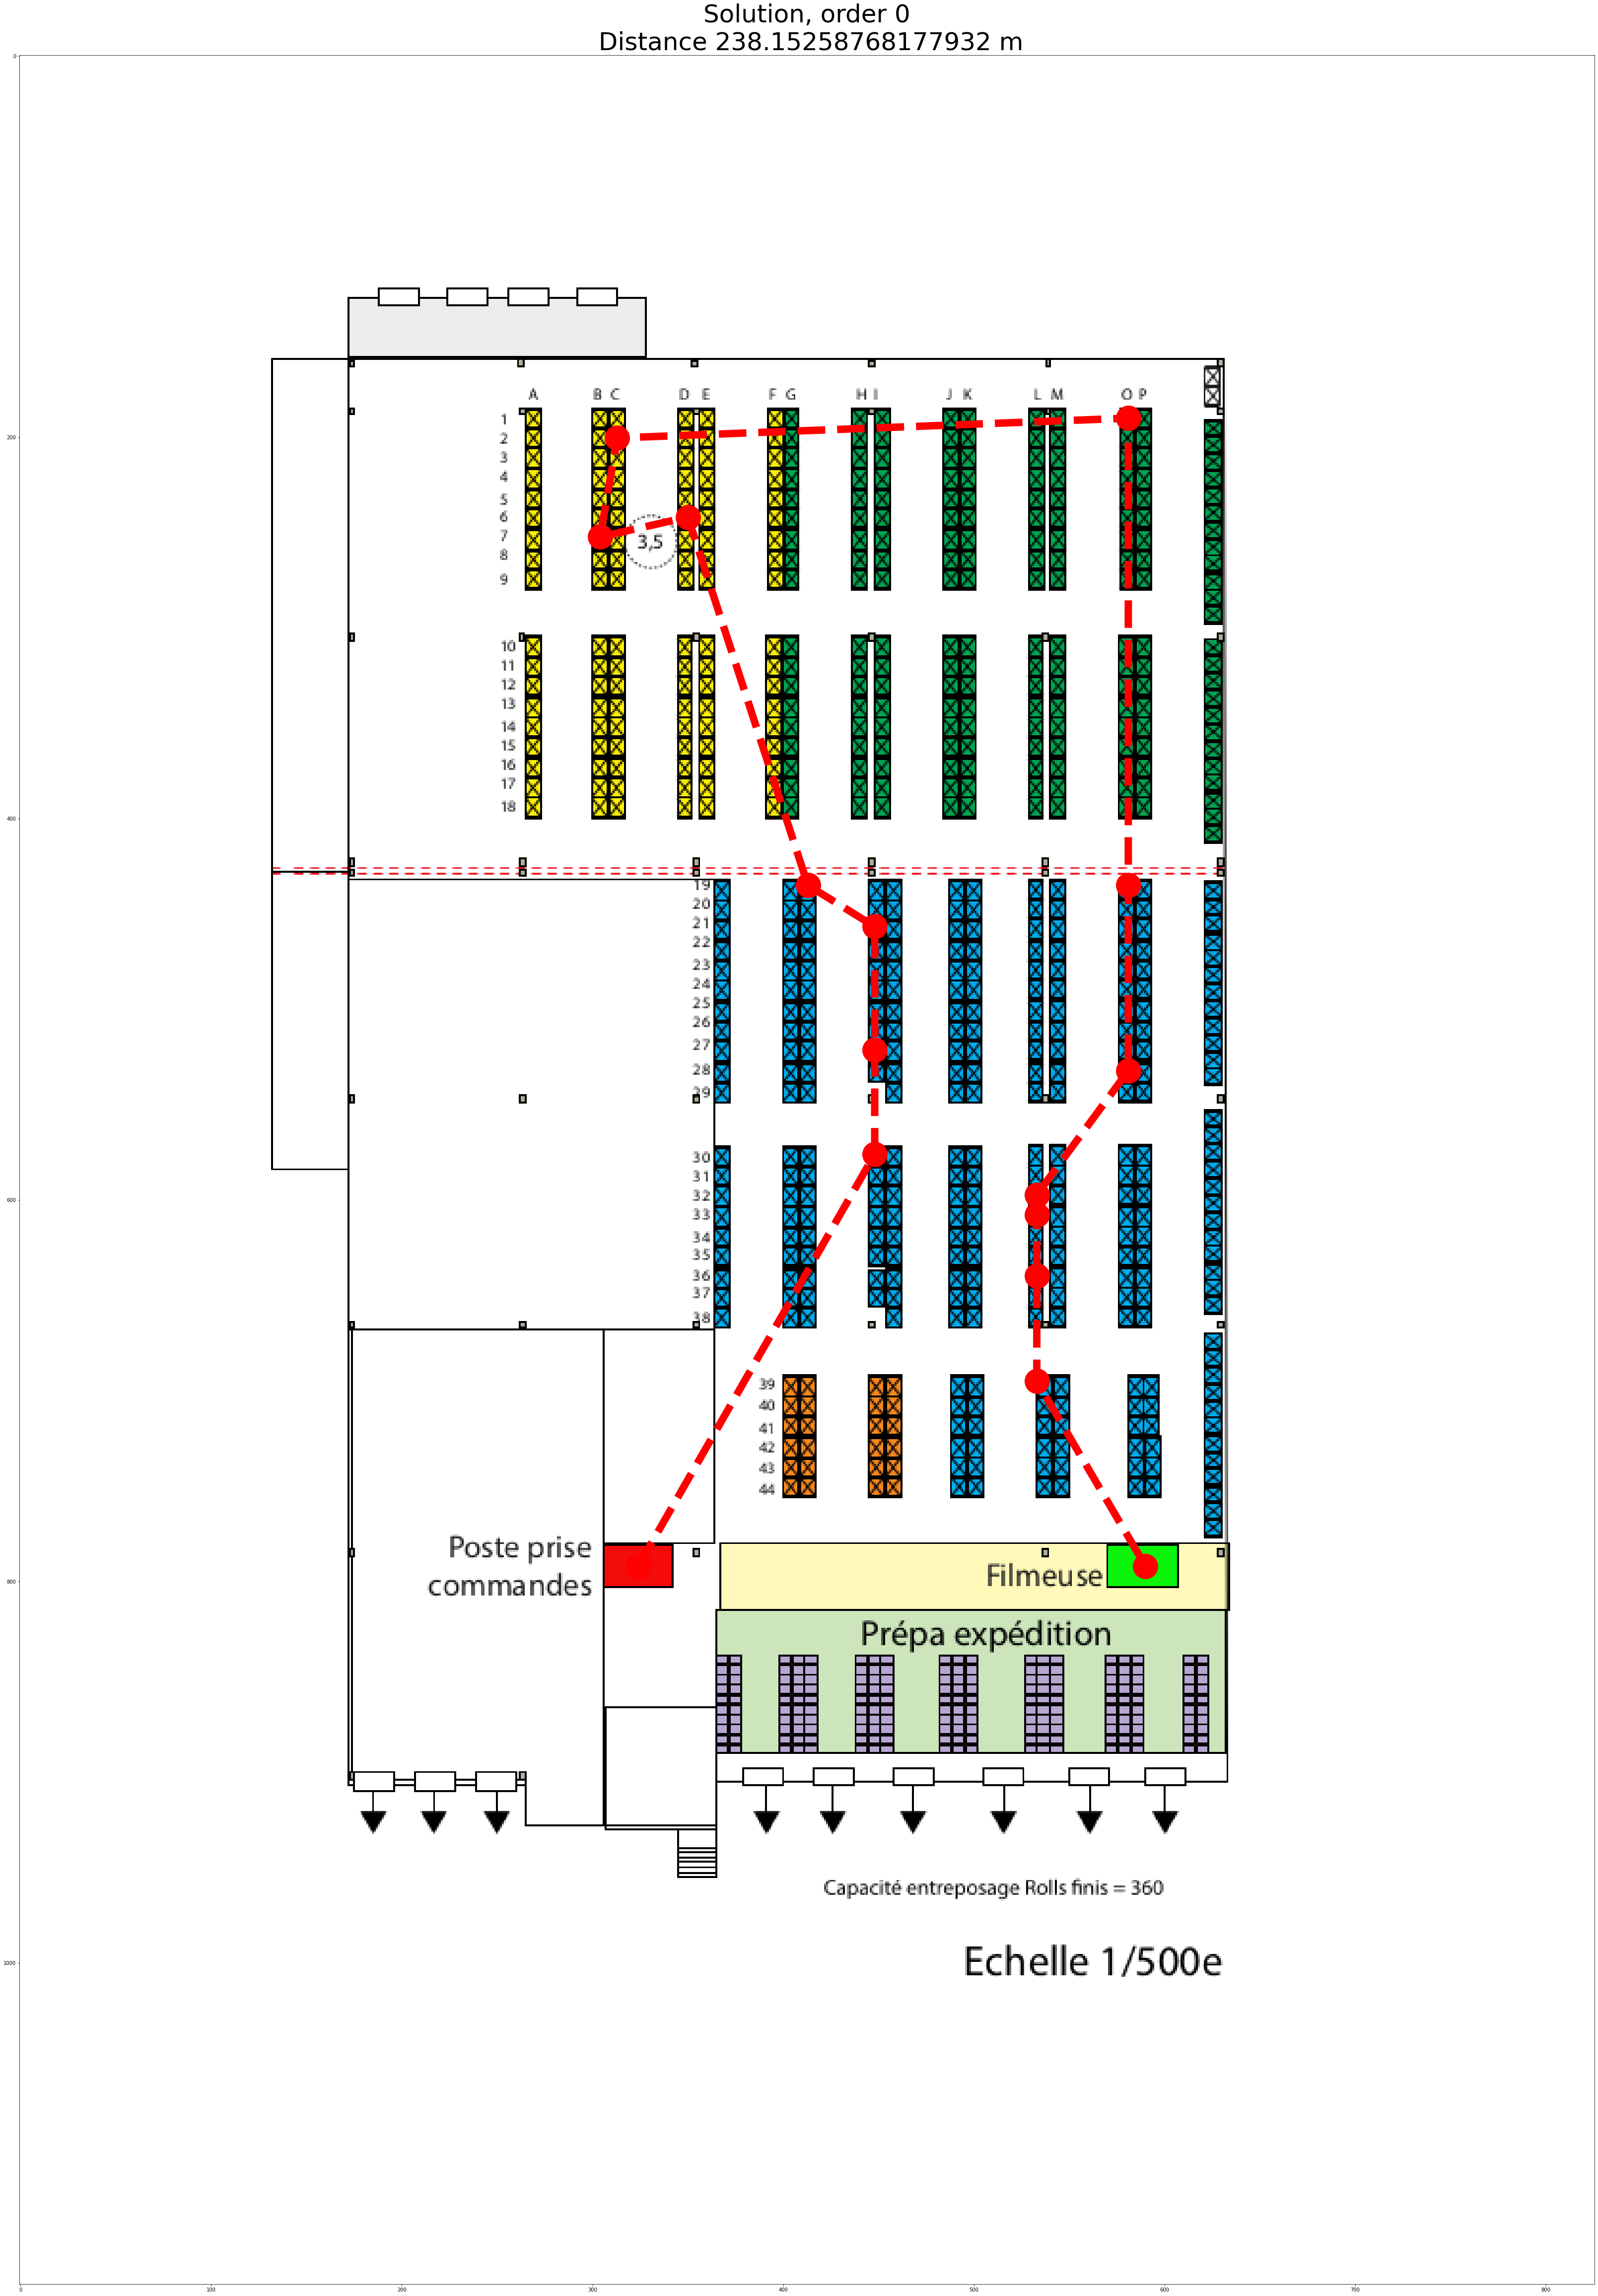

In [59]:
# Read plan
%matplotlib inline

plan = plt.imread(plan_file)
print("pixel shape:", plan.shape)
print("scale 1/500")
print(f"1 pixel = {scale} m")

# Display plan
reduction = 10
plt.figure(figsize=(1169/reduction, 826/reduction))
plt.imshow(plan)

# Solution
path_x = []
path_y = []
location_names = []
for loc in best_path:
    path_x.append(loc.x)
    path_y.append(loc.y)
    location_names.append(loc.name)
print(location_names)
plt.plot(path_x, path_y, "ro--", markersize=50, linewidth=15)
plt.title(f"Solution, order {n_order}\n Distance {best_distance * scale} m", size=50)
plt.savefig(f"solution_{n_order}.png", format="png")
plt.show()